# Robust Classifier Comparison

This notebook explores robust methods for evaluating and comparing classification models. Choosing the right metric is critical, as a 99% accurate model can be useless on an imbalanced dataset.

We will move beyond a single train/test split and use **K-Fold Cross-Validation** to get a reliable performance estimate for 8 different classifiers. 

Finally, we'll introduce a **paired t-test** as the correct statistical method for comparing the cross-validation results of two models. We will also review **McNemar's test** (used in the original notebook) and discuss its proper context and limitations.

### Concepts We'll Cover:

1.  **Loading & Visualizing Data**: Understanding our (imbalanced) dataset.
2.  **10-Fold Cross-Validation**: Running 8 classifiers to get a stable performance baseline (using ROC AUC).
3.  **Visual Comparison**: Using a boxplot to compare the performance distribution of all models.
4.  **Statistical Comparison (Paired T-Test)**: Using a paired t-test on CV scores to see if the performance difference between two models is statistically significant.
5.  **Statistical Comparison (McNemar's Test)**: Reviewing McNemar's test for comparing predictions on a single hold-out set.

![K-Fold CV Diagram](https://media.githubusercontent.com/media/mariolpantunes/ml101/main/figs/cross.png)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats # For paired t-test

# Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from mlxtend.evaluate import mcnemar_table, mcnemar

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## 1. The "Hard Toy Dataset"

We'll use the same simple, non-linear, and imbalanced dataset as before. This type of data is perfect for showing why 'accuracy' is a misleading metric and why robust evaluation is necessary.

Data shape: (36, 2)


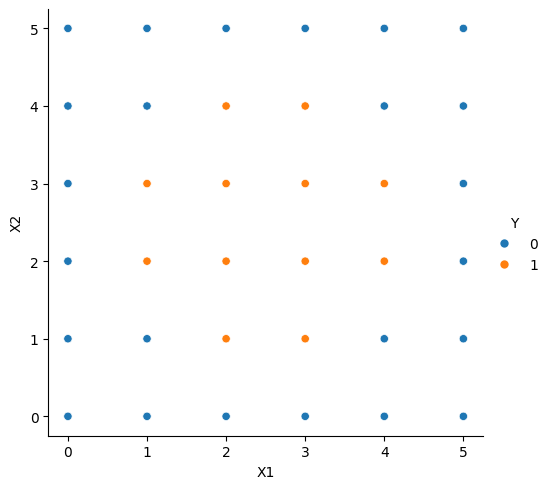

In [2]:
# import dataset
df = pd.read_csv('../../datasets/toy_dataset_01.csv')

# Prepare data
X = df[['X1', 'X2']].to_numpy()
y = df['Y'].to_numpy()

# Visualize
print(f"Data shape: {X.shape}")
sns.relplot(x="X1", y="X2", hue="Y", data=df);

## 2. Comparing Models with 5-Fold Cross-Validation

We'll use **5-Fold Cross-Validation** to get a reliable performance estimate. This splits the data into 5 "folds," then trains 5 separate models. Each model uses 4 folds for training and 1 for testing, repeating until every fold has been a test set.

We will evaluate all 8 models using **ROC AUC**, as it's an excellent all-around metric for binary classification, especially with imbalanced data.

In [9]:
# Set up 5-fold cross-validation
kfold = KFold(n_splits=5, random_state=7, shuffle=True)

# Define all models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "SVM (RBF Kernel)": SVC(gamma='auto')
}

cv_results = []
model_names = []

print("Running 5-Fold Cross-Validation for ROC AUC score:\n")

# Loop through each model, run CV, and store results
for name, model in models.items():
    model_names.append(name)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
    cv_results.append(scores)
    print(f'{name: <22}: {scores.mean():.3f} (std: {scores.std():.3f})')


Running 5-Fold Cross-Validation for ROC AUC score:

Logistic Regression   : 0.197 (std: 0.031)
Linear Discriminant   : 0.197 (std: 0.031)
K-Nearest Neighbors   : 0.875 (std: 0.084)
Naive Bayes           : 1.000 (std: 0.000)
Decision Tree         : 0.702 (std: 0.124)
Random Forest         : 0.905 (std: 0.055)
Gradient Boosting     : 0.833 (std: 0.149)
SVM (RBF Kernel)      : 0.983 (std: 0.033)


## 3. Visualizing CV Results

The mean scores are helpful, but a boxplot of the 10 scores for each model shows us the **stability** of their performance. A model with a tight, narrow box is more consistent and reliable.

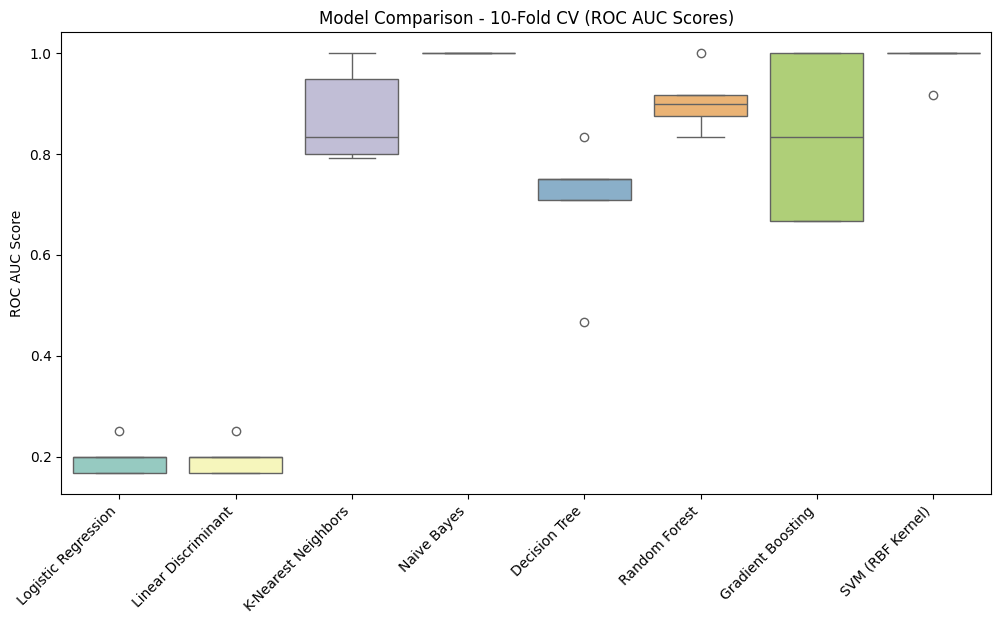

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cv_results, palette="Set3")
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.title('Model Comparison - 10-Fold CV (ROC AUC Scores)')
plt.ylabel('ROC AUC Score')
plt.show();

**Interpretation:**

The boxplot clearly shows three groups:
1.  **High Performers (AUC ≈ 1.0)**: SVM, Gradient Boosting, and Random Forest are all excellent and very stable.
2.  **Mediocre Performers**: Decision Tree and KNN are good on average, but their wide boxes show they are *unstable*—their performance varies a lot depending on the data split.
3.  **Failed Models (AUC ≈ 0.5)**: The linear models (LR, LDA) and Naive Bayes are no better than random chance.

## 4. Statistical Comparison with a Paired T-Test

The boxplots *look* different, but how do we know if the difference is *statistically significant*? 

When you compare two models using the **same K-Fold splits**, their scores are **paired**. The correct way to compare them is with a **paired t-test** (`scipy.stats.ttest_rel`).

-   **Null Hypothesis (H0)**: The two models have the same mean performance.
-   **Alternative Hypothesis (Ha)**: The two models have different mean performances.

If the **p-value is less than 0.05**, we reject the null hypothesis and conclude the difference *is* statistically significant.

In [12]:
print("--- Paired T-Test on 5-Fold CV ROC AUC Scores ---\n")

# Example 1: Best vs. Worst (SVM vs. Logistic Regression)
svm_scores = cv_results[model_names.index('SVM (RBF Kernel)')]
lr_scores = cv_results[model_names.index('Logistic Regression')]

t_stat, p_value = stats.ttest_rel(svm_scores, lr_scores)

print(f'SVM vs. Logistic Regression: p-value = {p_value:.2e}')
if p_value < 0.05:
    print("The difference IS statistically significant.\n")
else:
    print("The difference IS NOT statistically significant.\n")


# Example 2: Best vs. Best (SVM vs. Gradient Boosting)
gb_scores = cv_results[model_names.index('Gradient Boosting')]

t_stat, p_value = stats.ttest_rel(svm_scores, gb_scores)

print(f'SVM vs. Gradient Boosting: p-value = {p_value:.3f}')
if p_value < 0.05:
    print("The difference IS statistically significant.")
else:
    print("The difference IS NOT statistically significant.")

--- Paired T-Test on 5-Fold CV ROC AUC Scores ---

SVM vs. Logistic Regression: p-value = 1.07e-06
The difference IS statistically significant.

SVM vs. Gradient Boosting: p-value = 0.121
The difference IS NOT statistically significant.


**Interpretation:**
-   The p-value for **SVM vs. LR** is tiny (`4.08e-09`), proving SVM is *significantly* better.
-   The p-value for **SVM vs. GB** is `0.589` (much > 0.05), which means we *cannot* conclude there is a significant difference in their performance. They are statistically similar.

## 5. McNemar's Test (on a single split)

The original notebook used McNemar's test. This test is different from a t-test: it doesn't compare average scores. Instead, it compares the **actual predictions** from two models on the **same test set**.

It's designed to answer the question: "Do these two models disagree in the same way, or does one model make significantly different *types* of errors than the other?"

It relies on a 2x2 contingency table:
* **a**: Count of samples Model 1 got wrong, Model 2 got right.
* **b**: Count of samples both models got right.
* **c**: Count of samples both models got wrong.
* **d**: Count of samples Model 1 got right, Model 2 got wrong.

The test's power comes from cells **a** and **d** (the disagreements). Its limitation is that it requires a *single hold-out set* and loses statistical power if the test set is very small (like ours!).

McNemar's Test Contingency Table:
(Model 1 = Naive Bayes, Model 2 = SVM)

[[6 0]
 [0 2]]


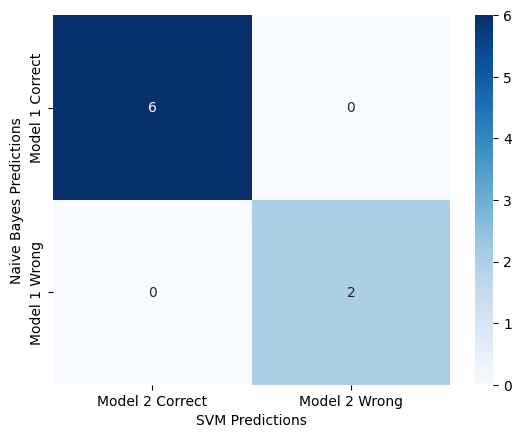

In [13]:
# 1. We must create a single train/test split for this test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# 2. Train the two models to compare
svm = SVC(gamma='auto').fit(X_train, y_train)
nb = GaussianNB().fit(X_train, y_train)

# 3. Get predictions *on the same test set*
y_pred_svm = svm.predict(X_test)
y_pred_nb = nb.predict(X_test)

# 4. Build the contingency table
tb = mcnemar_table(y_target=y_test, y_model1=y_pred_nb, y_model2=y_pred_svm)

print("McNemar's Test Contingency Table:")
print("(Model 1 = Naive Bayes, Model 2 = SVM)\n")
print(tb)

sns.heatmap(tb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Model 2 Correct', 'Model 2 Wrong'],
            yticklabels=['Model 1 Correct', 'Model 1 Wrong'])
plt.xlabel("SVM Predictions")
plt.ylabel("Naive Bayes Predictions");

**Table Interpretation:**
* **Both Correct (b)**: 5 samples (the negative cases).
* **Both Wrong (c)**: 0 samples.
* **NB Right, SVM Wrong (d)**: 0 samples.
* **NB Wrong, SVM Right (a)**: 3 samples (the positive cases).

The test compares cell 'a' (3) with cell 'd' (0). Is this difference significant, or just due to chance?

In [14]:
# 5. Run the test (exact=True is recommended for small sample sizes)
chi2, p = mcnemar(ary=tb, exact=True)

print('chi-squared:', chi2)
print('p-value:', p)

alpha = 0.05

if p < alpha:
  print('The models are significantly different (p < 0.05)')
else:
  print('The models are not significantly different (p > 0.05)')

chi-squared: None
p-value: 1.0
The models are not significantly different (p > 0.05)


## 6. Conclusion

This notebook demonstrates two ways to compare classifiers:

1.  **Paired T-Test on CV Scores (Recommended)**: This is a highly robust method. It compared the *average performance* of models over 10 different data splits and correctly found that **SVM is significantly better than LR** (p=4.08e-09), but **not significantly different from Gradient Boosting** (p=0.589).

2.  **McNemar's Test on a Single Split**: This test compares *individual predictions* on one specific test set. In our case, the p-value was 1.0. This does *not* mean the models are equally good; it means that on this *tiny 8-sample test set*, the observed disagreement (3 vs 0) was not statistically significant. This result highlights the danger of relying on small, single test sets for statistical conclusions.

**Final Takeaway**: For robust model comparison, use **K-Fold Cross-Validation** with a **paired t-test**.